In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tsa.api as smt
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

**Reading the data**

In [ ]:
df  = pd.read_csv('day.csv')
print(df.shape)
df.head()

## **Data Visualisation** 
Lets Summarize the data

In [ ]:
df.describe()

Data Types of columns

In [ ]:
df.info()

Check for Null Values

In [5]:
df.isna().sum()


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

No Null values present in the data.<br>

We can remove instant,dteday,casual and Registered as cnt is sum of casual and registered and instant is index and we got all details from dteday.

In [6]:
df.drop(columns = ["instant","dteday","casual","registered"],inplace =True)

Let's look at the pair plot of thw whole data

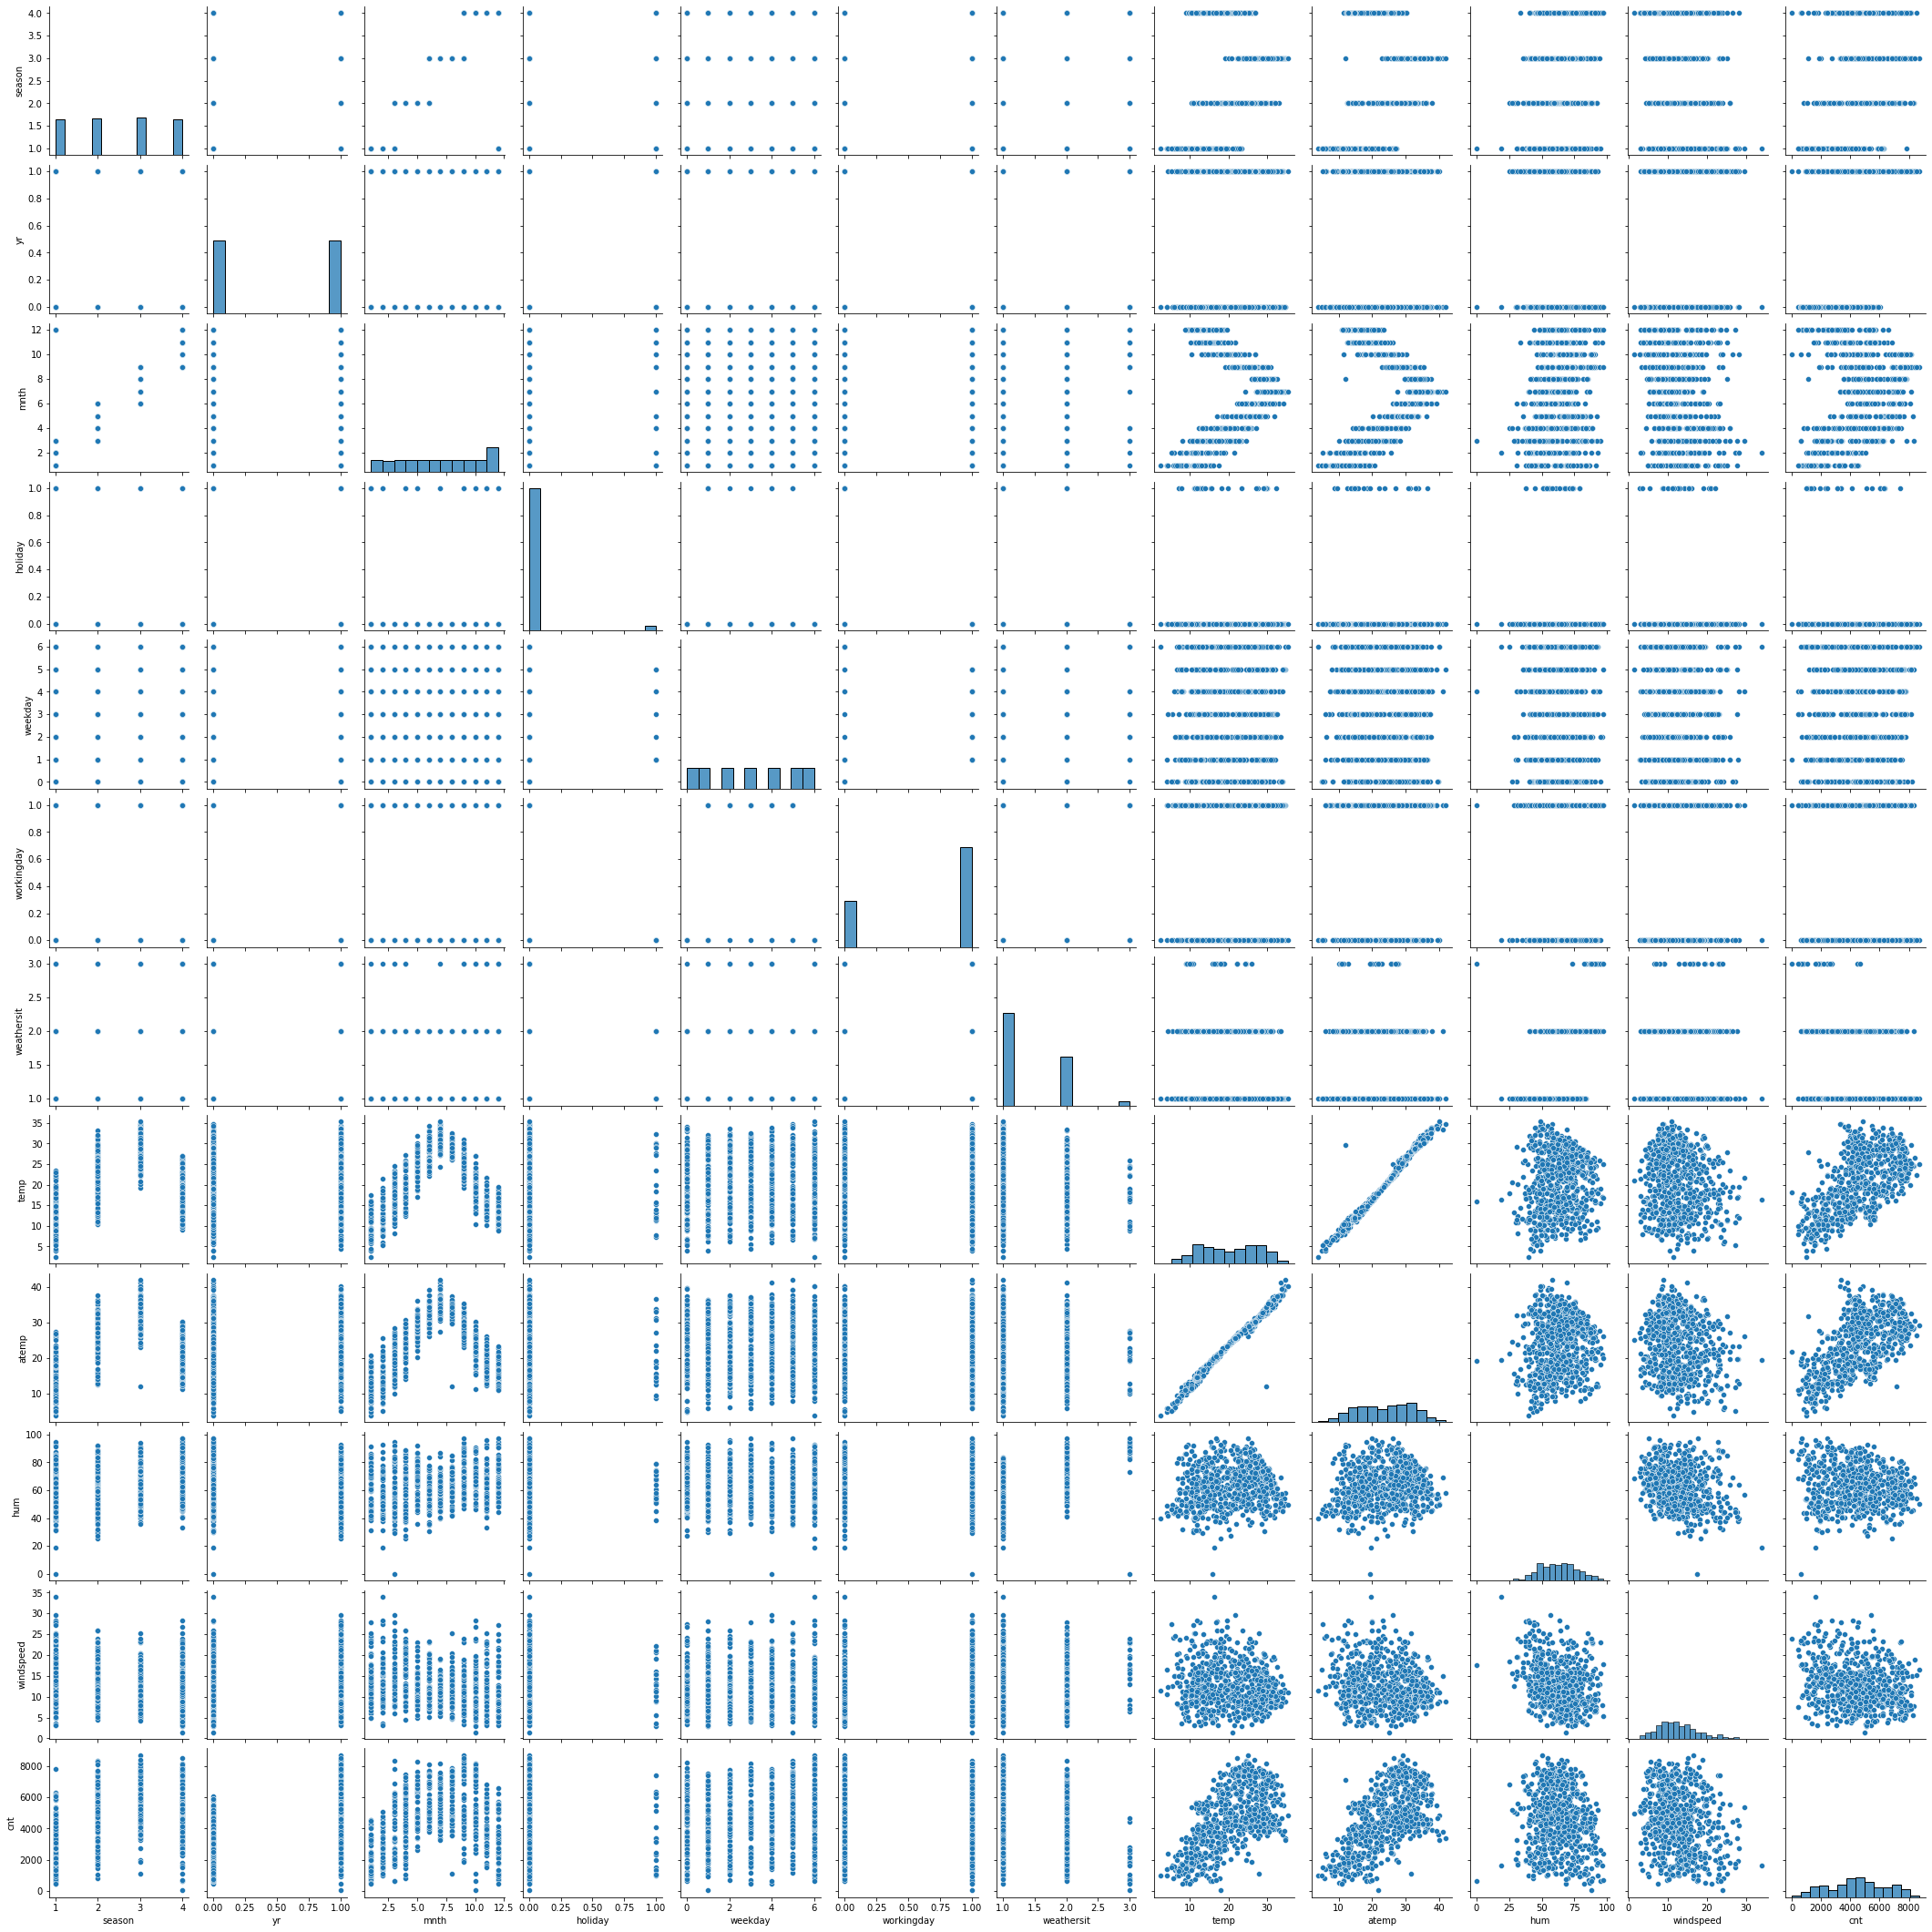

In [7]:
sns.pairplot(df)

As we can observe the pairplot is too clumsy lets, separate the numerical and categorical variables

In [8]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [9]:
cat = ["season","yr","mnth","holiday","weekday","workingday","weathersit"]
num = ["temp","atemp","hum","windspeed"]
df['weathersit'] = df['weathersit'].map({1:'Clear', 2:'Cloudy', 3:'LSLR', 4:'HRHS'})

Lets look at the pairplot of only Numerical variables.

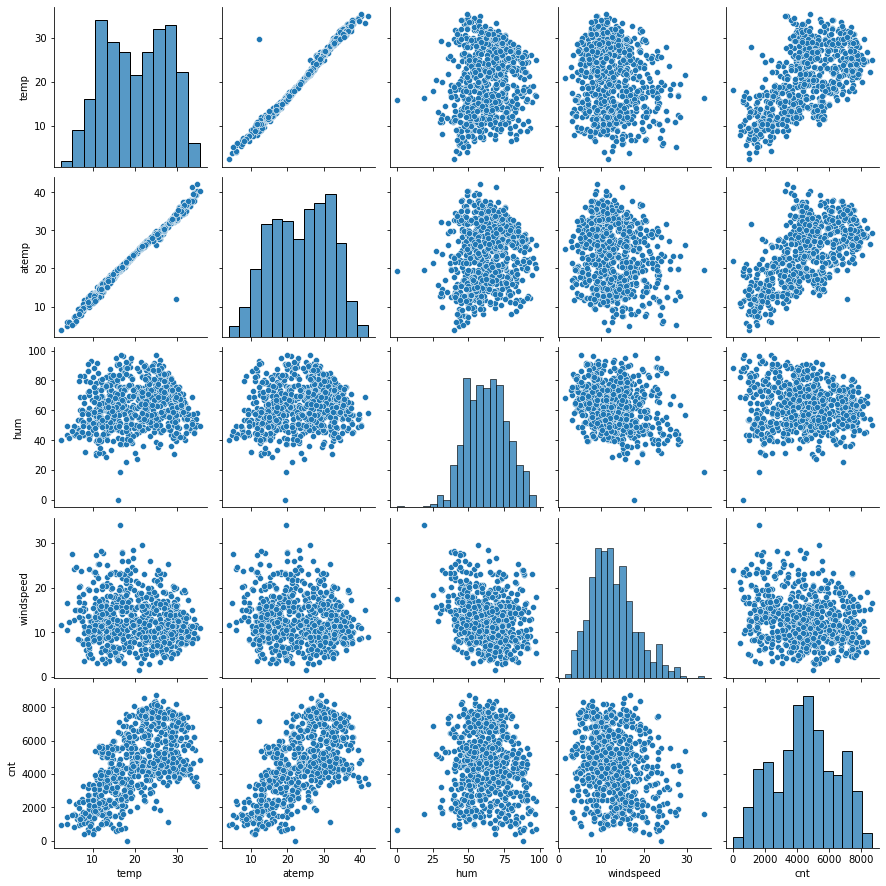

In [10]:
sns.pairplot(df[num+["cnt"]])

We can observe that temp and atemp are higly correlated to each other, and these two variables are also related to count.

Now let us observe the effect of categorical variables.

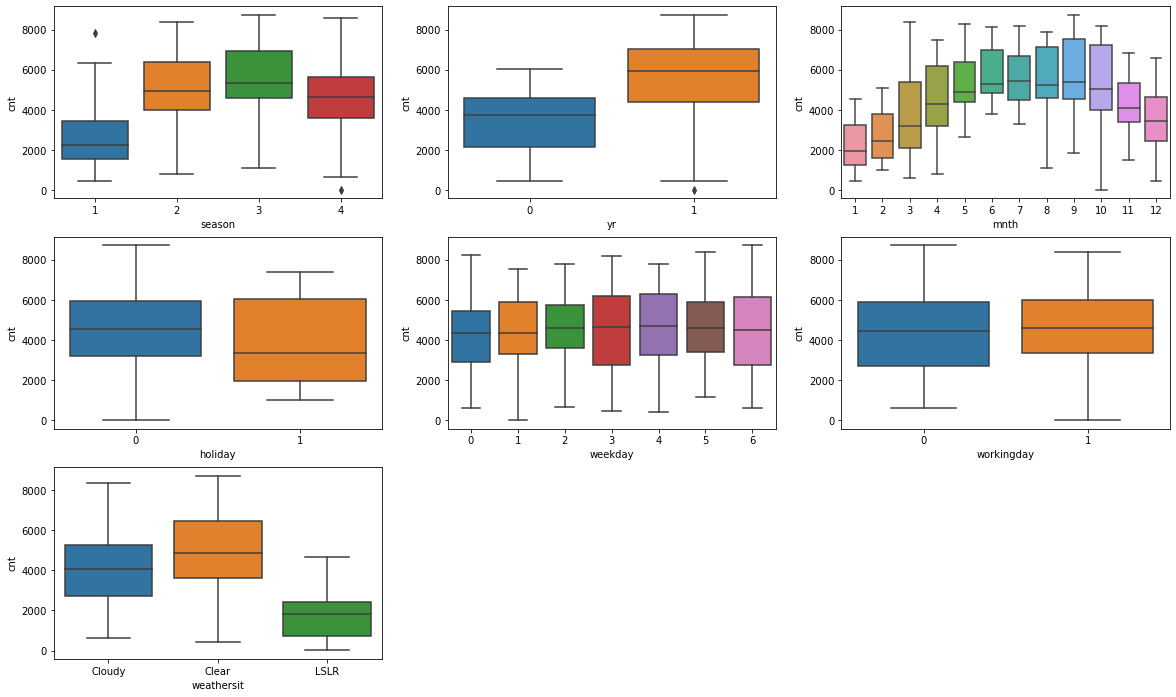

In [11]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = cat[0], y = 'cnt', data = df)
plt.subplot(3,3,2)
sns.boxplot(x = cat[1], y = 'cnt', data = df)
plt.subplot(3,3,3)
sns.boxplot(x = cat[2], y = 'cnt', data = df)
plt.subplot(3,3,4)
sns.boxplot(x = cat[3], y = 'cnt', data = df)
plt.subplot(3,3,5)
sns.boxplot(x = cat[4], y = 'cnt', data = df)
plt.subplot(3,3,6)
sns.boxplot(x = cat[5], y = 'cnt', data = df)
plt.subplot(3,3,7)
sns.boxplot(x = cat[6], y = 'cnt', data = df)
plt.show()


* From the graphs we can observe that weekday and workingday has no effect on CNT variable.
* We can observe that the median of the yr in 2019 is greater than 2018 which says the cnt variable is more in year 2019.
* We can also observe that there is some pattern in month, Season and weathersit vaariable's.
* We can see on holidays bike count is less.

Lets See the Correlation Heat-map

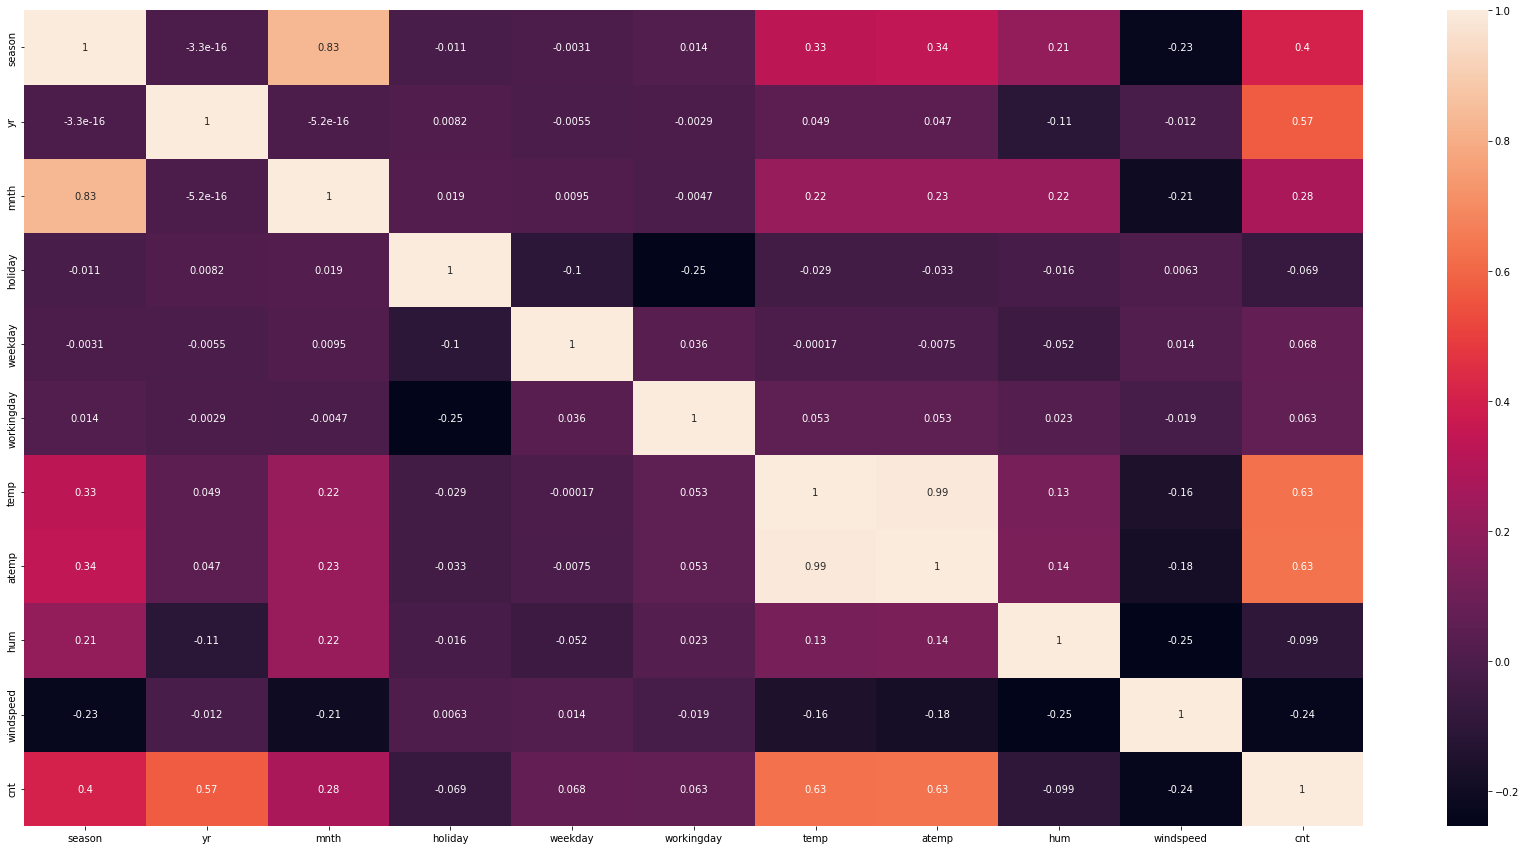

In [12]:
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), annot = True)
plt.show()

* From the Heat map we can clearly see that season and month are higly correlated.
* Cnt is correlated with yr,temp and atemp.
* Temp and atemp are higly correlated with 0.99 so we can clearly have to remove one variable.


## **Data Preparation**

Lets Decrypt the categorical variables Season and weather as per readme.txt and create dummy variables for these two variables.

In [13]:

def season_enc(x):
    return x.map({1: "Spring", 2: "summer",3:"fall",4:"winter"})
def weather_enc(x):
    return x.map({1:"Clear",2:"Mist",3:"Light Snow",4:"Heavy Rain"})

enc_df = df.copy()
enc_df[["season"]] = enc_df[["season"]].apply(season_enc)
enc_df[["weathersit"]] = enc_df[["weathersit"]].apply(weather_enc)
enc_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,1,0,6,0,NaN,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,1,0,0,0,NaN,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,1,0,1,1,NaN,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,1,0,2,1,NaN,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,1,0,3,1,NaN,9.305237,11.46350,43.6957,12.522300,1600


In [14]:
temp = pd.get_dummies(enc_df[["season","weathersit"]],drop_first="True")
temp.head()

,season_fall,season_summer,season_winter
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


Lets join the dummy variables to our enc_df and drop the original variables.

In [15]:
enc_df = pd.concat([enc_df, temp], axis = 1)
enc_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,season_fall,season_summer,season_winter
0,Spring,0,1,0,6,0,NaN,14.110847,18.18125,80.5833,10.749882,985,0,0,0
1,Spring,0,1,0,0,0,NaN,14.902598,17.68695,69.6087,16.652113,801,0,0,0
2,Spring,0,1,0,1,1,NaN,8.050924,9.47025,43.7273,16.636703,1349,0,0,0
3,Spring,0,1,0,2,1,NaN,8.200000,10.60610,59.0435,10.739832,1562,0,0,0
4,Spring,0,1,0,3,1,NaN,9.305237,11.46350,43.6957,12.522300,1600,0,0,0


In [16]:
enc_df.drop(columns = ["season","weathersit"], axis = 1, inplace = True)
enc_df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_fall,season_summer,season_winter
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0


We can see that temp and atemp are higly correlated so we need to remove one variable, Lets calculate the VIF an decide which variable to remove.

Let's Divide the data into training and test set.

In [17]:
df_train, df_test = train_test_split(enc_df, train_size = 0.7, test_size = 0.3, random_state = 100)

Lets Scale the Numerical variables.

In [18]:
num

['temp', 'atemp', 'hum', 'windspeed']

In [19]:
scaler = MinMaxScaler()
df_train[num+["cnt"]] = scaler.fit_transform(df_train[num+["cnt"]])

In [20]:
df_train.describe()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_fall,season_summer,season_winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000
mean,0.507843,6.549020,0.025490,2.990196,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.262745,0.245098,0.24902
std,0.500429,3.468714,0.157763,2.017093,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.440557,0.430568,0.43287
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,3.000000,0.000000,1.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000
50%,1.000000,7.000000,0.000000,3.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000
75%,1.000000,10.000000,0.000000,5.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,1.000000,0.000000,0.00000
max,1.000000,12.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Lets Divide the data into independent and dependent Variables.

In [21]:
y_train = df_train.pop('cnt')
X_train = df_train

## ***Data Modeling and Evaluation***

Lets store X_train data frame in X_train_copy as backup.

In [22]:
X_train_copy = X_train.copy()

Lets see the correlation of the newly formed variables.

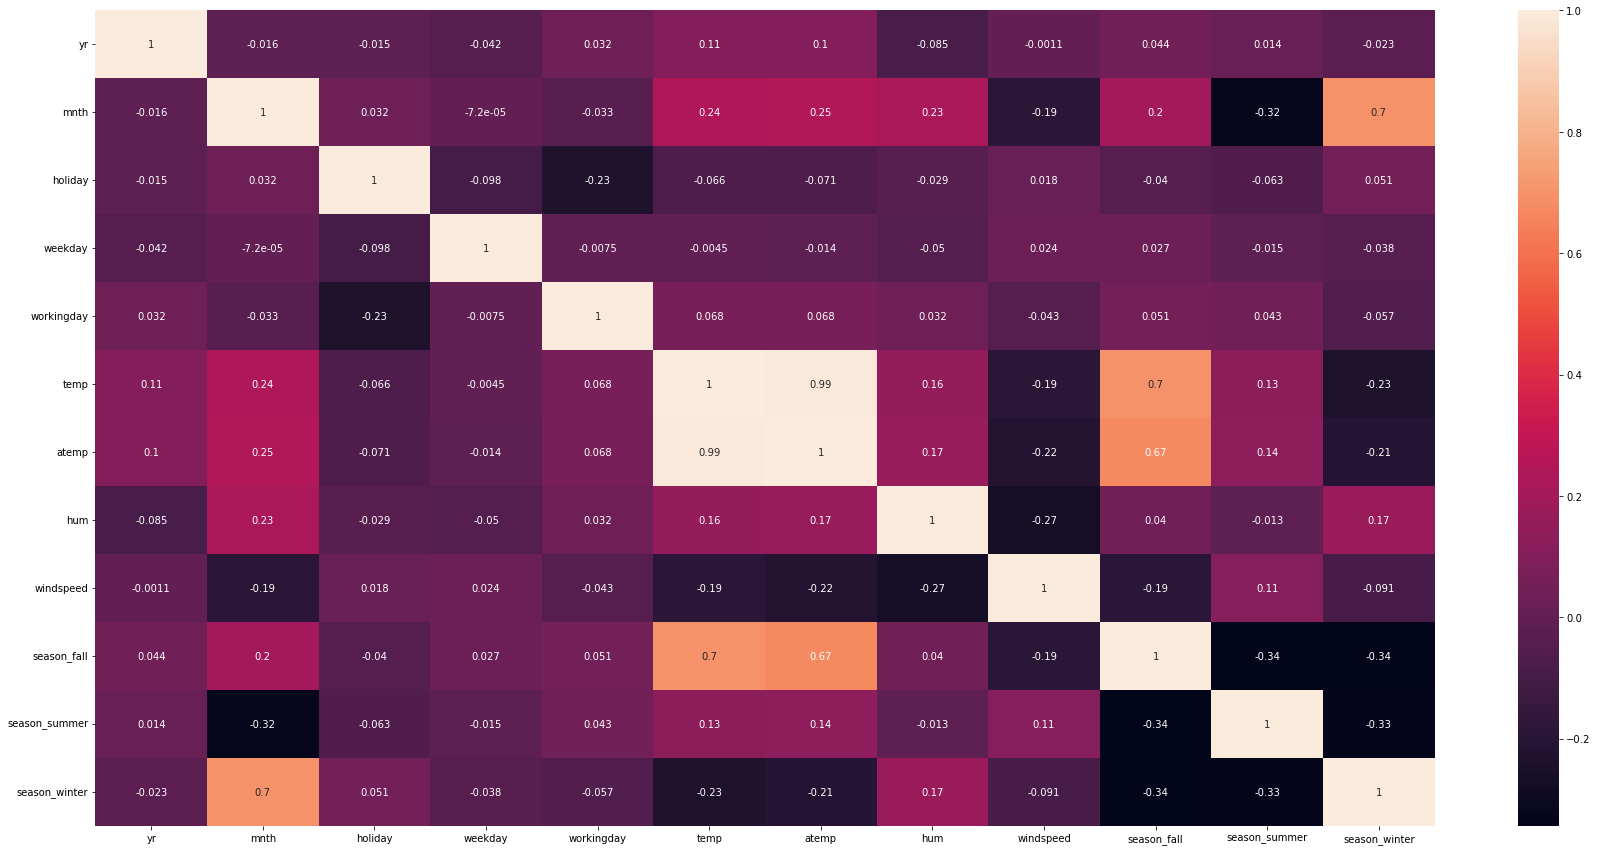

In [23]:
plt.figure(figsize = (30, 15))
sns.heatmap(df_train.corr(), annot = True)
plt.show()

In [24]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,temp,385.41
6,atemp,361.92
1,mnth,17.21
7,hum,12.70
9,season_fall,7.96
11,season_winter,7.03
8,windspeed,3.99
10,season_summer,3.47
4,workingday,3.13
3,weekday,3.04


Now we will drop the temp variable as its VIF is greater than all.

In [25]:
X_train.drop(columns=["temp"],inplace=True)


Lets store all the confirmed delete variables in conf_del_cols list to keep track of deleted variables.

In [26]:
conf_del_cols = ["temp"]

Now we will Observe the VIF values after deleting temp.

In [27]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,atemp,19.70
1,mnth,17.21
6,hum,12.69
8,season_fall,7.32
10,season_winter,7.03
7,windspeed,3.81
9,season_summer,3.40
4,workingday,3.13
3,weekday,3.04
0,yr,2.02


Let's Create a model with all the remaining variables.

In [28]:
X_train_lm = sm.add_constant(X_train)
lr_1 = sm.OLS(y_train, X_train_lm).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     182.3
Date:                Wed, 11 May 2022   Prob (F-statistic):          1.06e-166
Time:                        16:52:31   Log-Likelihood:                 450.30
No. Observations:                 510   AIC:                            -876.6
Df Residuals:                     498   BIC:                            -825.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2604      0.030      8.598

We Observe that mnth variable is having high P-value and high VIF , some can drop this variable.

In [29]:
X_train.drop(columns=["mnth"],inplace=True)

In [30]:
X_train_lm = sm.add_constant(X_train)

lr_2 = sm.OLS(y_train, X_train_lm).fit()

print(lr_2.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     200.4
Date:                Wed, 11 May 2022   Prob (F-statistic):          1.24e-167
Time:                        16:52:31   Log-Likelihood:                 449.75
No. Observations:                 510   AIC:                            -877.5
Df Residuals:                     499   BIC:                            -830.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2659      0.030      8.922

We Observe that The R-square value Adjusted R-square value Doesnt change so we can say that mnth doesnot have any effect on model.

In [31]:
conf_del_cols.append("mnth")

In [32]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,atemp,19.47
5,hum,11.78
7,season_fall,5.83
6,windspeed,3.75
8,season_summer,3.27
3,workingday,3.13
2,weekday,3.00
9,season_winter,2.47
0,yr,2.02
1,holiday,1.08


Lets Drop atemp variable because it's having high VIF value, And see how model behaves.

In [33]:
X_train.drop(columns=["atemp"],inplace=True)

In [34]:
X_train_lm = sm.add_constant(X_train)

lr_3 = sm.OLS(y_train, X_train_lm).fit()

print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     137.6
Date:                Wed, 11 May 2022   Prob (F-statistic):          3.53e-129
Time:                        16:52:31   Log-Likelihood:                 356.23
No. Observations:                 510   AIC:                            -692.5
Df Residuals:                     500   BIC:                            -650.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3884      0.034     11.297

We can see that by dropping atemp we saw the decrease in R^2 and Adj R^2 value so we should not drop that column.
<br><br> Lets backup the data.

In [35]:
X_train = X_train_copy.copy()
X_train.drop(columns=conf_del_cols,inplace=True)

Lets use **RFE** to select top features to build the model.


In [36]:
lm_rfe = LinearRegression()
lm_rfe.fit(X_train, y_train)

rfe = RFE(lm_rfe)         
rfe = rfe.fit(X_train, y_train)

In [37]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', False, 4),
 ('weekday', False, 6),
 ('workingday', False, 5),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_fall', False, 3),
 ('season_summer', False, 2),
 ('season_winter', True, 1)]

Lets take only the column values with ranking as 1

In [39]:
X_train = X_train_copy[["yr","atemp","hum","windspeed","season_winter"]]

In [40]:
X_train_lm = sm.add_constant(X_train)

lr_5 = sm.OLS(y_train, X_train_lm).fit()

print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     340.1
Date:                Wed, 11 May 2022   Prob (F-statistic):          6.64e-159
Time:                        16:54:18   Log-Likelihood:                 414.78
No. Observations:                 510   AIC:                            -817.6
Df Residuals:                     504   BIC:                            -792.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2892      0.030      9.794

We can Clearly see that all the p values are small enough to reject the null hypothesis<br><br>
Now lets see the VIF values of these selected variables.

In [41]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,9.80
1,atemp,6.92
3,windspeed,3.40
0,yr,2.00
4,season_winter,1.46


Lets drop the Hum variable as it is having highest VIF nearer to 10.

In [42]:
X_train.drop(columns=["hum"],inplace=True)

Lets build the model again.

In [43]:
X_train_lm = sm.add_constant(X_train)

lr_6 = sm.OLS(y_train, X_train_lm).fit()

print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     353.5
Date:                Wed, 11 May 2022   Prob (F-statistic):          7.69e-145
Time:                        16:54:26   Log-Likelihood:                 378.91
No. Observations:                 510   AIC:                            -747.8
Df Residuals:                     505   BIC:                            -726.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0912      0.020      4.504

Lets Check VIF Values

In [44]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,atemp,3.05
2,windspeed,2.72
0,yr,1.99
3,season_winter,1.22


We can observe that all the variables are having VIF < 5 which is good enough to go a head.

###  Residual Analysis

In [45]:
y_pred = lr_6.predict(X_train_lm)

Lets Draw the histogram of errors

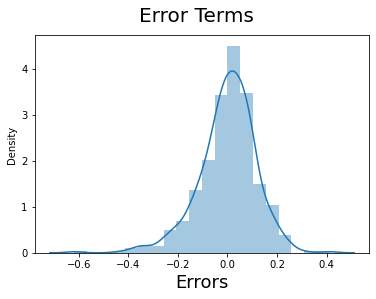

In [46]:
fig = plt.figure()
residual = y_train - y_pred
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)            
plt.xlabel('Errors', fontsize = 18)  
plt.show()

As we can see that error terms are following Normal Distribution with mean as 0(Zero).

Lets Plot the q-q Plot 

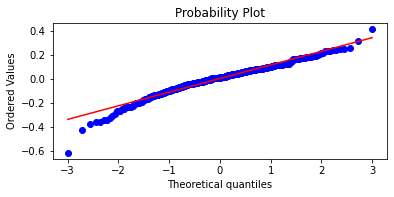

In [47]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

We can Clearly see that the points are forming straight line which says booth set of quantiles came rom the same distribution.

Lets Draw the Scatter Plot of Residuals

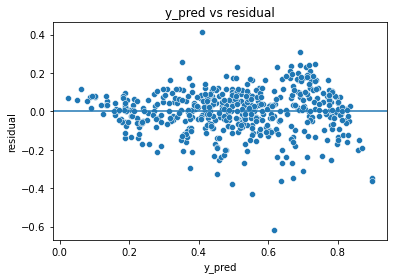

In [48]:
s = sns.scatterplot(y_pred,residual)
s.set_title("y_pred vs residual")
s.set(xlabel='y_pred', ylabel='residual')
s.axhline(0)
plt.show()

We can clearly see that the graph is representing **Homoscedasticity**

Lets Draw the Auto correlation factor graph for the Residuals.

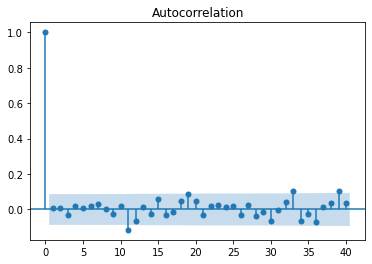

In [49]:
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.05)

We can see that the data is having randomness.

### Model Evaluation

Lets use our Scalar fitted with train data to transform test data.

In [50]:
df_test[num+["cnt"]] = scaler.transform(df_test[num+["cnt"]])

In [51]:
df_test.describe()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_fall,season_summer,season_winter
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,6.474886,0.036530,3.018265,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592,0.246575,0.264840,0.232877
std,0.500722,3.421875,0.188034,1.988415,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435,0.432005,0.442259,0.423633
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000
25%,0.000000,4.000000,0.000000,1.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,0.000000
50%,0.000000,6.000000,0.000000,3.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,0.000000
75%,1.000000,9.000000,0.000000,5.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745,0.000000,1.000000,0.000000
max,1.000000,12.000000,1.000000,6.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000


Lets Divide scaled data intoo X_test and y_test.

In [52]:
y_test = df_test.pop('cnt')
X_test = df_test

Now only select the columns that we used in our final modeland store the data in X_test_new. 

In [53]:
X_test_new = X_test[X_train.columns]

Add the constant.

In [54]:
X_test_new = sm.add_constant(X_test_new)

Lets get the predictions for the test data .

In [55]:
y_pred = lr_6.predict(X_test_new)

Now we will draw scatter plot between y_test and y_pred to see weather they are following the pattern or not.

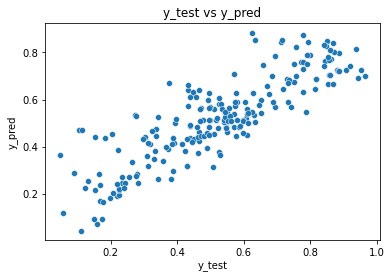

In [56]:
s = sns.scatterplot(y_test,y_pred)
s.set_title("y_test vs y_pred")
s.set(xlabel='y_test', ylabel='y_pred')
plt.show()

From the graph we can clearly see that y_pred and y_test are following the pattern and they are mostly similar to each other.

Lets get the predictions for trainigdata also to see how well our model performed on **Training data vs Test Data** .

In [57]:
y_train_pred = lr_6.predict(X_train_lm)

In [58]:
print("Model Performance on Train Data Set")
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_pred))
print("Coefficient of determination(R^2): %.2f" % r2_score(y_train, y_train_pred))
x = 1-(1-r2_score(y_train, y_train_pred))*(len(X_train)-1)/(len(X_train)-5-1)
print("Adjusted R^2: %.2f" % x)

Model Performance on Train Data Set
Mean squared error: 0.01
Coefficient of determination(R^2): 0.74
Adjusted R^2: 0.73


In [59]:
print("Model Performance on Test Data Set")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination(R^2): %.2f" % r2_score(y_test, y_pred))
x = 1-(1-r2_score(y_test, y_pred))*(len(X_test)-1)/(len(X_test)-5-1)
print("Adjusted R^2: %.2f" % x)


Model Performance on Test Data Set
Mean squared error: 0.01
Coefficient of determination(R^2): 0.73
Adjusted R^2: 0.72


We can see that the model performance on test data set is almost similar to performance on train data set.

Lets Plot the Actual and Predicted values of cnt for both Test and Train data.

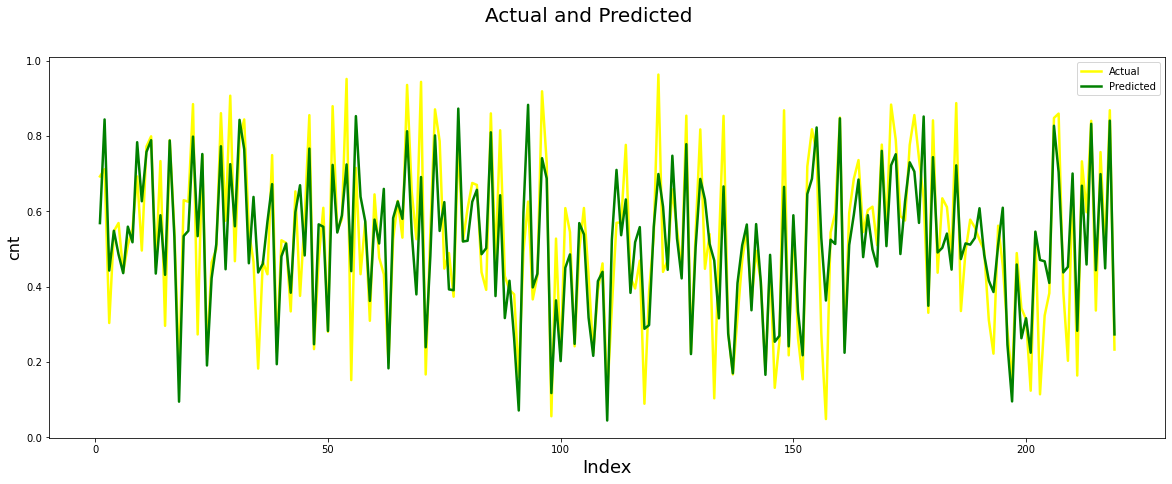

In [60]:
c = [i for i in range(1,len(X_test)+1,1)]
fig = plt.figure(figsize=(20,7))
plt.plot(c,y_test, color="yellow",  linewidth=2.5, linestyle="-",label="Actual")
plt.plot(c,y_pred, color="green", linewidth=2.5, linestyle="-",label="Predicted")

fig.suptitle('Actual and Predicted', fontsize=20)             
plt.xlabel('Index', fontsize=18)                               
plt.ylabel('cnt', fontsize=16)   
plt.legend()
plt.show()

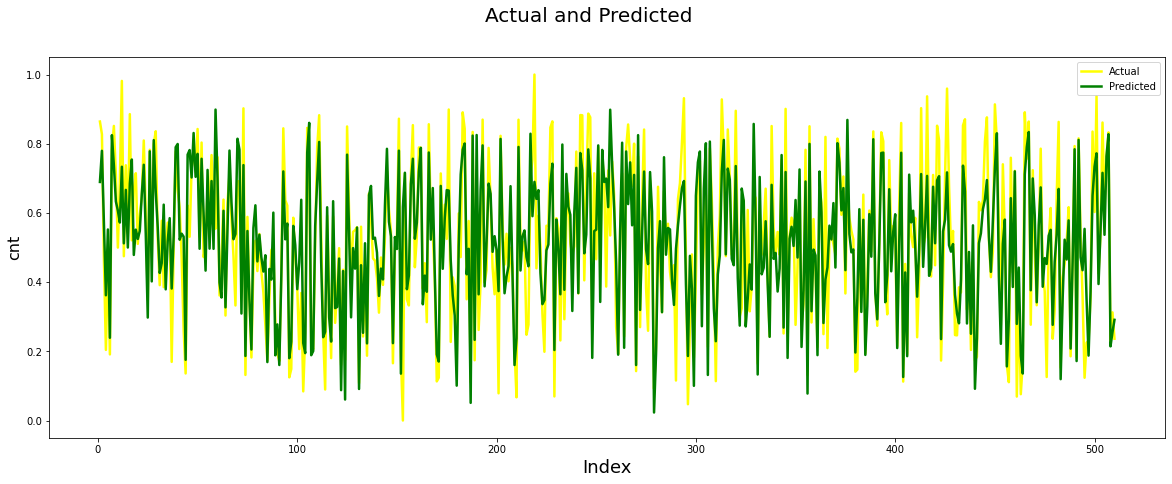

In [61]:
c = [i for i in range(1,len(X_train)+1,1)]
fig = plt.figure(figsize=(20,7))

plt.plot(c,y_train, color="yellow",  linewidth=2.5, linestyle="-",label="Actual")
plt.plot(c,y_train_pred, color="green", linewidth=2.5, linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)             
plt.xlabel('Index', fontsize=18)                               
plt.ylabel('cnt', fontsize=16)    
plt.legend()
plt.show()

Lets Summarize the Final Model

In [62]:
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     353.5
Date:                Wed, 11 May 2022   Prob (F-statistic):          7.69e-145
Time:                        16:55:29   Log-Likelihood:                 378.91
No. Observations:                 510   AIC:                            -747.8
Df Residuals:                     505   BIC:                            -726.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0912      0.020      4.504


We can see that the equation of our best fitted line is:

$ cnt =0.0892 + 0.2341  \times  yr + 0.6381  \times  atemp + 0.095 \times season winter - 0.12 \times windspeed - 0.02409 \times weathersit Light Snow $


Overall we have a good decent model, but we also acknowledge that we could do better. 

We have a couple of options:
1. Add new features (week of month,temp by month , etc.)
2. Build a non-linear model.